## Darshan Nyati
In my github repository there is a markdown file for insights, although
I have also comment down the insights and resources that I used and  found at the bottom of  each cell wherever needed.

**Models used**: Ridge Regression, Random Forest, Gradient Boosting, XGBoost

## reason why I selected particular models.


### Ridge Regression
Regularised linear model included as baseline to quantify how much predictive signal is non-linear.If Ridge matches tree models, simpler linear solution is also good

---

### Random Forest
Handles non-linear relations natively. Low risk of overfitting due to variance reduction from averaging 200 trees.

---



### Gradient Boosting
Builds trees sequentially, each correcting prior residuals.  


---

### XGBoost
it also builds trees sequentially, each correcting prior residuals. captures non linear relationships but It also handles large datasets efficiently, reduces overfitting through regularization, and generally provides high prediction accuracy.

---




##Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor

)
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

import xgboost as xgb

sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams.update({'font.size': 11, 'figure.dpi': 120})
COLORS = ['#2E86AB', '#E84855', '#3BB273', '#F4A261', '#9B5DE5']


##Loading the  data

In [2]:
df = pd.read_csv('Predicting Energy Consumption.csv')
df.columns = ['start_time', 'end_time', 'consumption']
df['timestamp'] = pd.to_datetime(df['start_time'], format='%m/%d/%Y %H:%M')
df = df.sort_values('timestamp').reset_index(drop=True)[['timestamp', 'consumption']]

print(f"Records       : {len(df):,}")
print(f"Date range    : {df['timestamp'].min()}  to  {df['timestamp'].max()}")
print(f"Consumption   : min={df['consumption'].min():,}  max={df['consumption'].max():,} MWh")
print(f"Missing values: {df['consumption'].isna().sum()}")
df.head(8)


Records       : 52,966
Date range    : 2015-12-31 21:00:00  to  2021-12-31 20:00:00
Consumption   : min=5,341  max=15,105 MWh
Missing values: 0


,timestamp,consumption
0,2015-12-31 21:00:00,10800
1,2015-12-31 22:00:00,10431
2,2015-12-31 23:00:00,10005
3,2016-01-01 00:00:00,9722
4,2016-01-01 01:00:00,9599
5,2016-01-01 02:00:00,9524
6,2016-01-01 03:00:00,9601
7,2016-01-01 04:00:00,9793


##Exploratory Data Analysis:
I am using only the Start time UTC column for analysis because it represents the exact timestamp when each hourly electricity measurement begins. Since the data is recorded hourly and in sequence, one timestamp per record is sufficient to model the time series. The End time UTC column does not add additional predictive value and would introduce redundancy.

### Analysing rolling trends


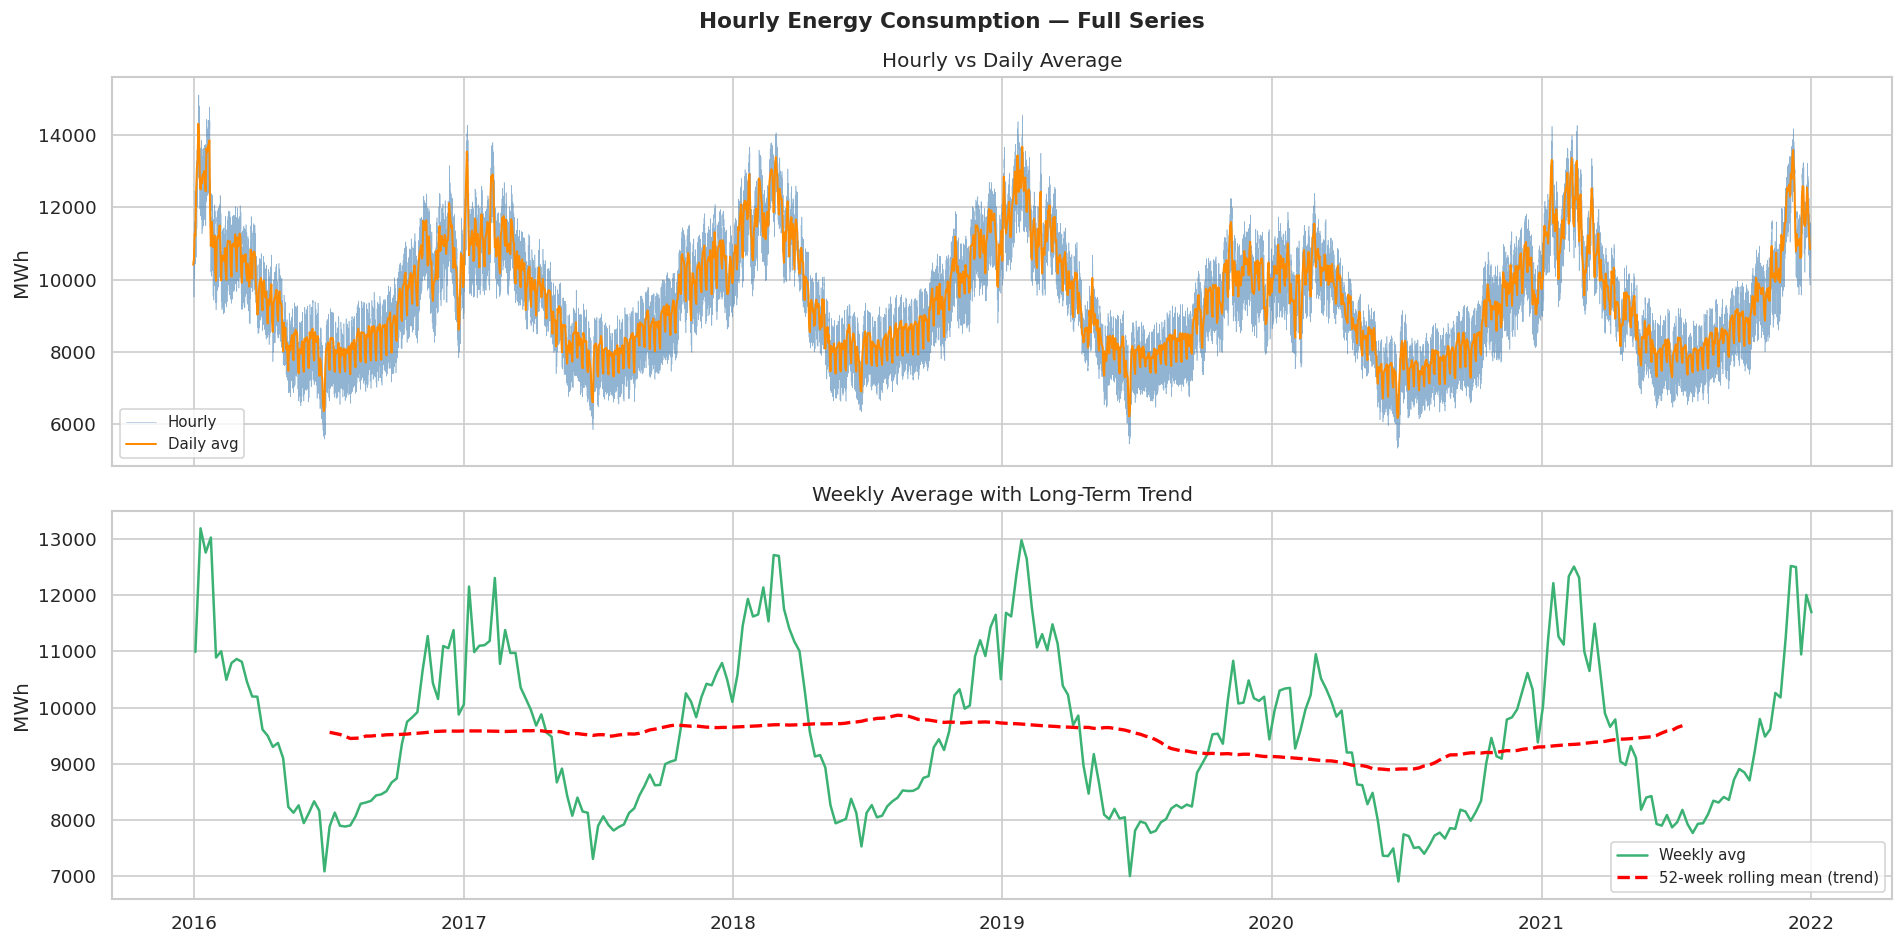

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8), sharex=True)
fig.suptitle('Hourly Energy Consumption — Full Series', fontsize=13, fontweight='bold')

ts = df.set_index('timestamp')['consumption']
daily  = ts.resample('D').mean()
weekly = ts.resample('W').mean()

#hourly
axes[0].plot(ts.index, ts.values, color='steelblue', linewidth=0.35, alpha=0.6, label='Hourly')
axes[0].plot(daily.index, daily.values, color='darkorange', linewidth=1.2, label='Daily avg')
axes[0].set_ylabel('MWh')
axes[0].legend(fontsize=9)
axes[0].set_title('Hourly vs Daily Average')

#weekly rolling mean
axes[1].plot(weekly.index, weekly.values, color='#3BB273', linewidth=1.5, label='Weekly avg')
roll52 = weekly.rolling(52, center=True).mean()
axes[1].plot(roll52.index, roll52.values, color='red', linewidth=2,
             linestyle='--', label='52-week rolling mean (trend)')
axes[1].set_ylabel('MWh')
axes[1].legend(fontsize=9)
axes[1].set_title('Weekly Average with Long-Term Trend')

plt.tight_layout()
plt.savefig('fig_timeseries.png', bbox_inches='tight')
plt.show()


# The 52-week rolling mean is nearly flat across 2016-2021,
# confirming stable demand with no significant growth.

# Although the electricity usage changes a lot from hour to hour,
#these changes follow a regular pattern that repeats over time.
#This means the overall behavior is not random.
#If we use time based information like day , we can predict future electricity demand.


###  Monthly & Hourly Seasonal Patterns

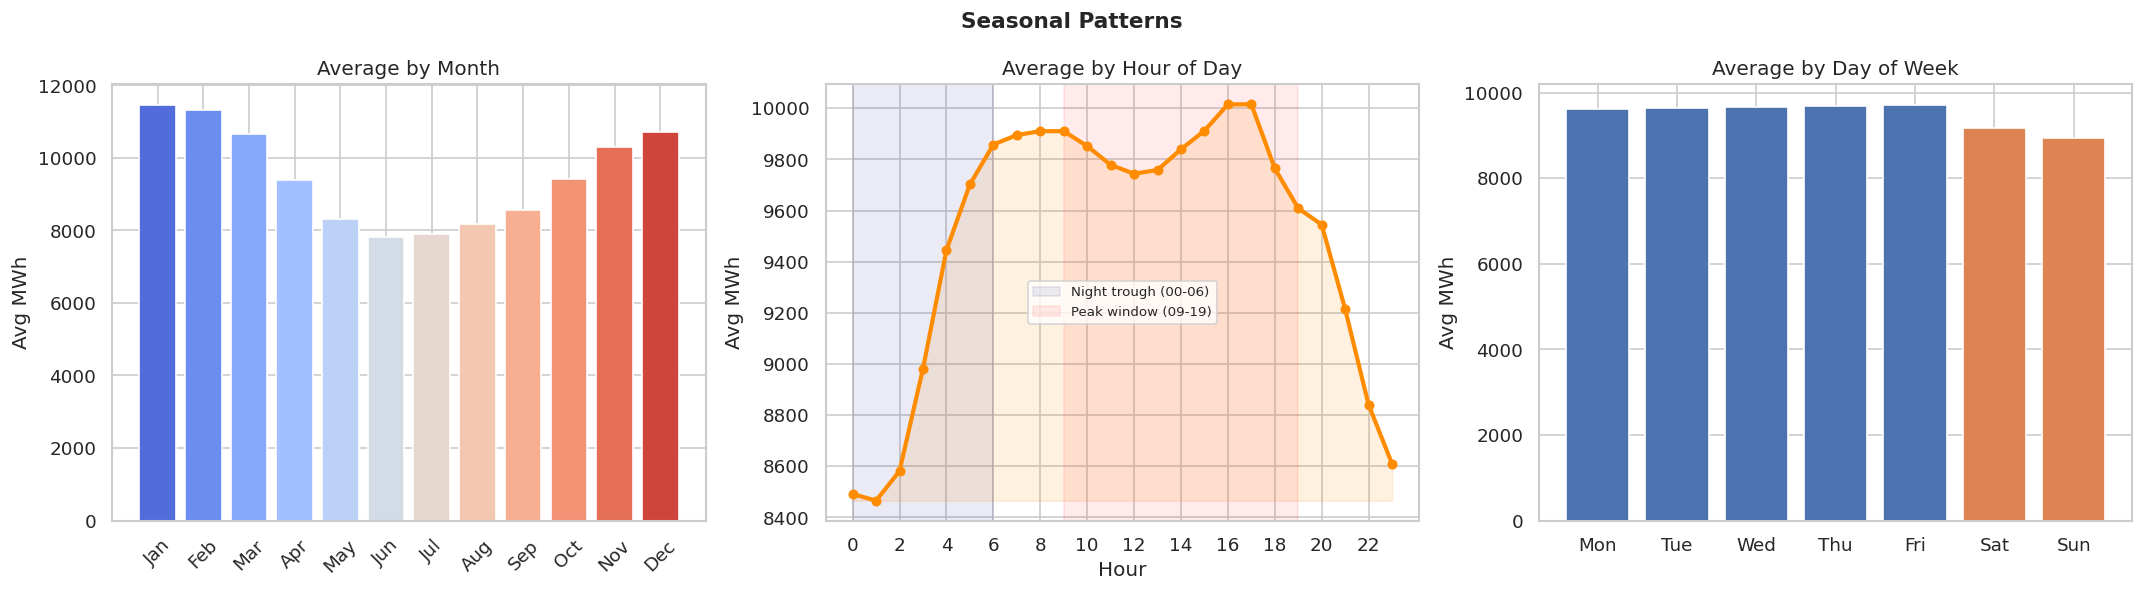

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Seasonal Patterns', fontsize=13, fontweight='bold')

# Monthly
df['month']     = df['timestamp'].dt.month
df['hour']      = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['year']      = df['timestamp'].dt.year

month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
monthly = df.groupby('month')['consumption'].mean()
axes[0].bar(monthly.index, monthly.values,
            color=sns.color_palette('coolwarm', 12), edgecolor='white')
axes[0].set_xticks(range(1,13)); axes[0].set_xticklabels(month_labels, rotation=45)
axes[0].set_title('Average by Month')
axes[0].set_ylabel('Avg MWh')

# peak demands in Jan-Mar and Oct-Dec. low demands in May-July


# Hourly
hourly = df.groupby('hour')['consumption'].mean()
axes[1].plot(hourly.index, hourly.values, 'o-', color='darkorange',
             linewidth=2.5, markersize=5)
axes[1].fill_between(hourly.index, hourly.values,
                      hourly.values.min(), alpha=0.12, color='darkorange')
axes[1].axvspan(0, 6,  alpha=0.08, color='navy',  label='Night trough (00-06)')
axes[1].axvspan(9, 19, alpha=0.08, color='red',   label='Peak window (09-19)')
axes[1].set_xticks(range(0,24,2))
axes[1].set_title('Average by Hour of Day')
axes[1].set_xlabel('Hour')
axes[1].set_ylabel('Avg MWh')
axes[1].legend(fontsize=8)

# start and end of the day have low consumptions.

# Day-of-week
dow_labels = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
dow = df.groupby('dayofweek')['consumption'].mean()
colors_dow = ['#4C72B0']*5 + ['#DD8452']*2
axes[2].bar(dow_labels, dow.values, color=colors_dow)
axes[2].set_title('Average by Day of Week')
axes[2].set_ylabel('Avg MWh')

# Weekdays have almost same  and slight higher demand than weekends.

plt.tight_layout()
plt.savefig('fig_seasonal.png', bbox_inches='tight')
plt.show()
# peak demands in Jan-Mar and Oct-Dec. low demands in May-July
# Weekdays have almost same  and slight higher demand than weekends.
# start and end of the day have low consumptions.


###Heatmap:Hours and Months


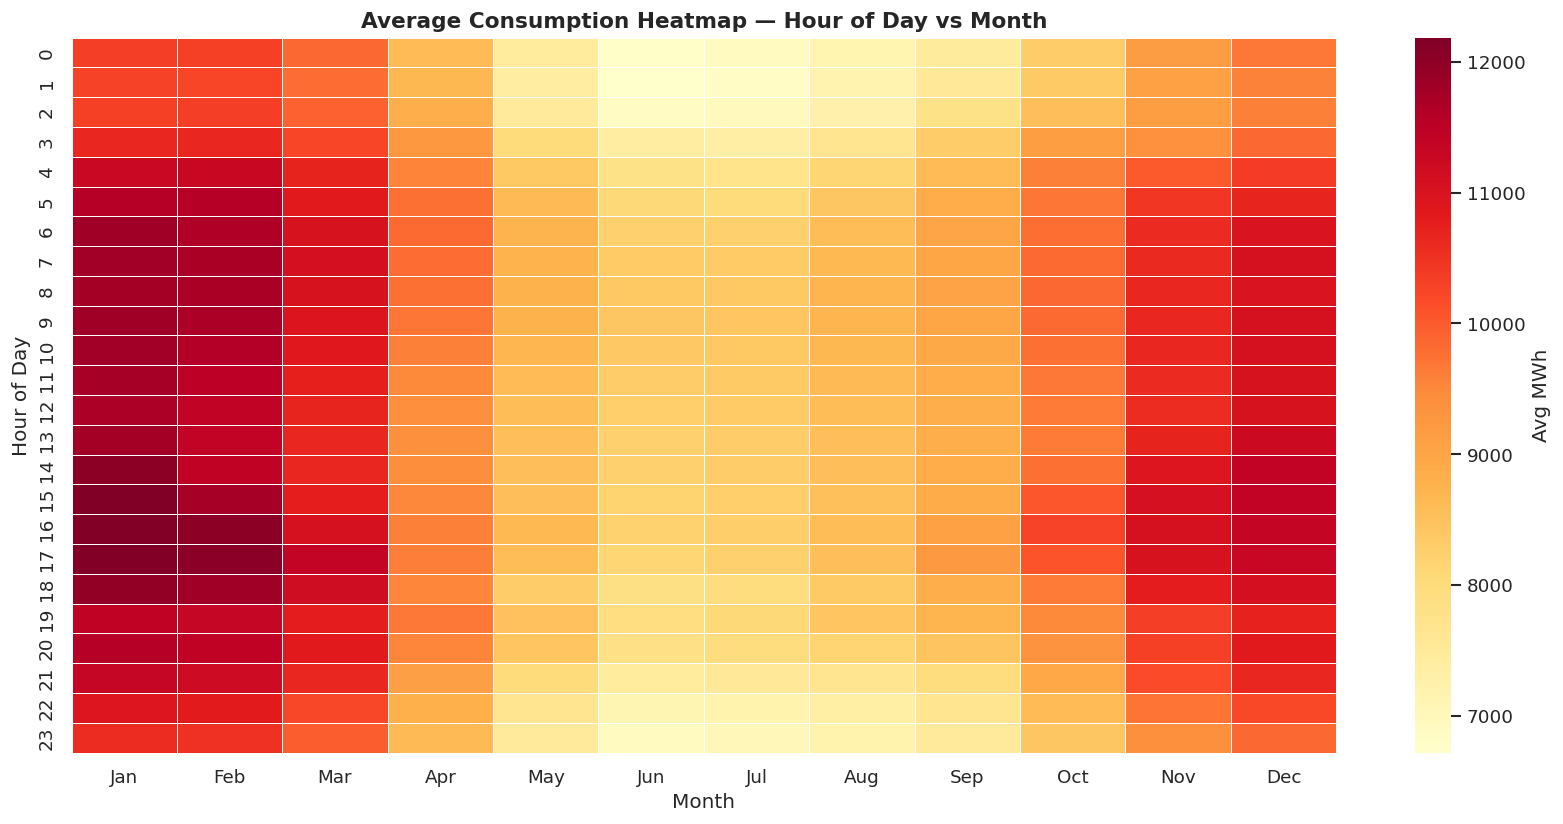

In [5]:
pivot = df.pivot_table(values='consumption', index='hour', columns='month', aggfunc='mean')
pivot.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(figsize=(14, 7))
sns.heatmap(pivot, cmap='YlOrRd', fmt='.0f', annot=False,
            linewidths=0.3, ax=ax, cbar_kws={'label': 'Avg MWh'})
ax.set_title('Average Consumption Heatmap — Hour of Day vs Month', fontsize=13, fontweight='bold')
ax.set_xlabel('Month'); ax.set_ylabel('Hour of Day')
plt.tight_layout()
plt.savefig('fig_heatmap_hour_month.png', bbox_inches='tight')
plt.show()

#Electricity demand is highest during the daytime (9 AM to 7 PM)


### Heatmap: Day of Week and Month

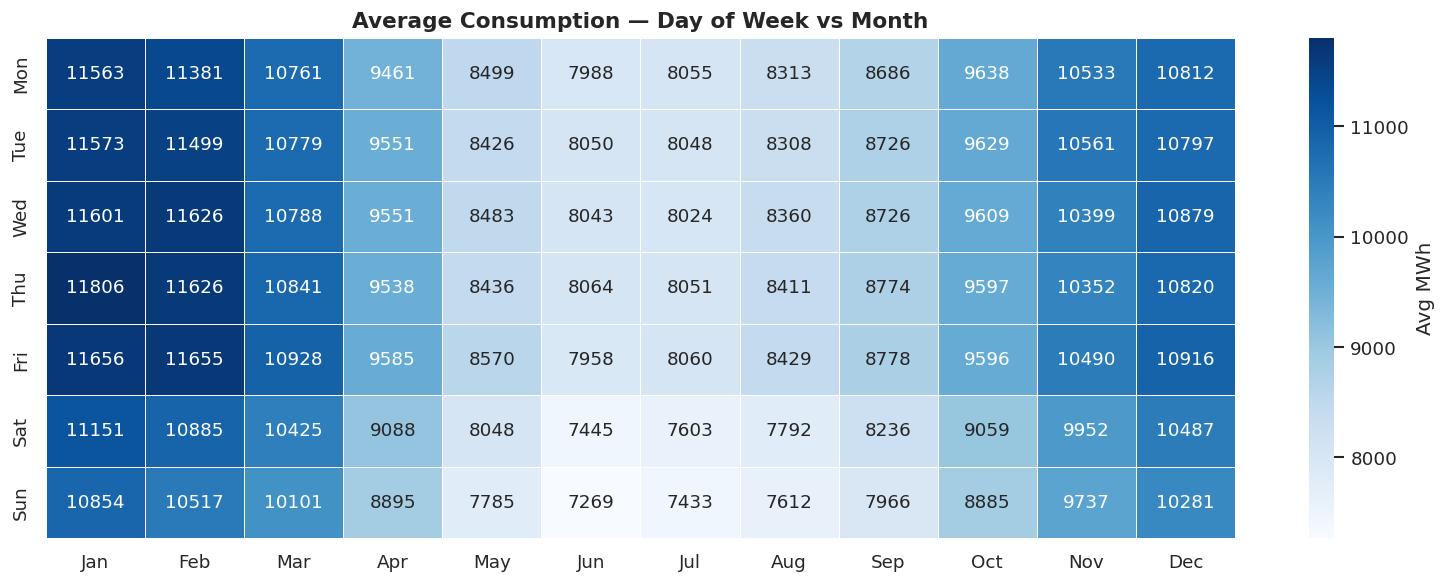

In [6]:
pivot2 = df.pivot_table(values='consumption', index='dayofweek', columns='month', aggfunc='mean')
pivot2.index = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
pivot2.columns = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax = plt.subplots(figsize=(13, 5))
sns.heatmap(pivot2, cmap='Blues', annot=True, fmt='.0f',
            linewidths=0.4, ax=ax, cbar_kws={'label': 'Avg MWh'})
ax.set_title('Average Consumption — Day of Week vs Month', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig('fig_heatmap_dow_month.png', bbox_inches='tight')
plt.show()


# Electricity demand is lower on weekends compared to weekdays throughout the year.


###  Distribution and Yearly Box Plots

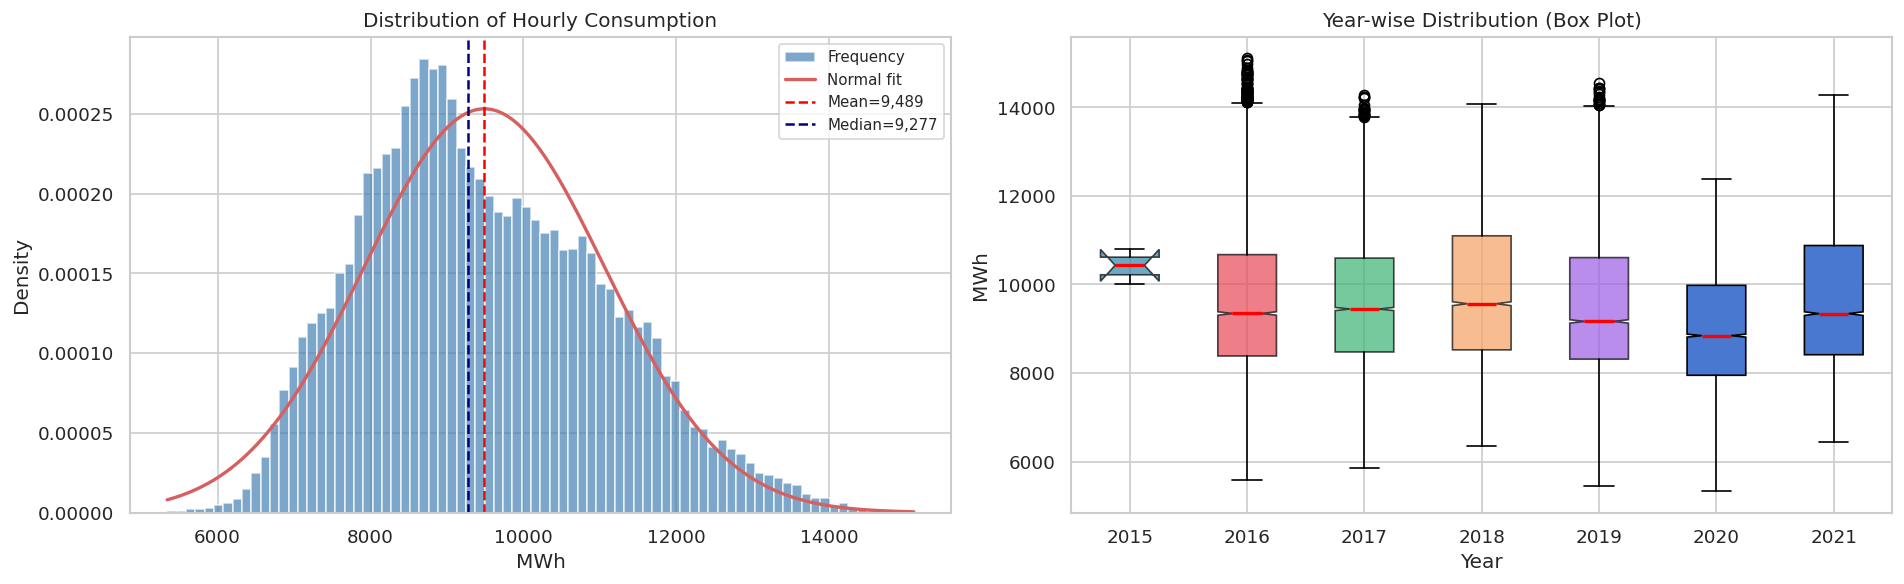

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Distribution
axes[0].hist(df['consumption'], bins=80, color='steelblue', alpha=0.7,
             density=True, edgecolor='white', label='Frequency')
mu, sigma = df['consumption'].mean(), df['consumption'].std()
x = np.linspace(df['consumption'].min(), df['consumption'].max(), 300)
axes[0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
axes[0].axvline(mu,             color='red',  linestyle='--', linewidth=1.5,
                label=f'Mean={mu:,.0f}')
axes[0].axvline(df['consumption'].median(), color='navy', linestyle='--', linewidth=1.5,
                label=f'Median={df["consumption"].median():,.0f}')
axes[0].set_title('Distribution of Hourly Consumption')
axes[0].set_xlabel('MWh'); axes[0].set_ylabel('Density')
axes[0].legend(fontsize=9)

# Year-wise boxplot
year_data = [df[df['year']==yr]['consumption'].values for yr in sorted(df['year'].unique())]
bp = axes[1].boxplot(year_data, patch_artist=True, notch=True,
                      labels=sorted(df['year'].unique()),
                      medianprops=dict(color='red', linewidth=2))
for patch, color in zip(bp['boxes'], COLORS):
    patch.set_facecolor(color); patch.set_alpha(0.7)
axes[1].set_title('Year-wise Distribution (Box Plot)')
axes[1].set_xlabel('Year'); axes[1].set_ylabel('MWh')

plt.tight_layout()
plt.savefig('fig_distribution.png', bbox_inches='tight')
plt.show()

# The distribution is approximately bell-shaped but left-skewed,
# indicating more hours of moderate-low consumption (overnight/weekends)
# than extreme highs. The mean slightly exceeds the median

# Year-on-year boxplots show nearly identical medians and IQRs
# across 2016-2021.


### 3.6  Autocorrelation Analysis

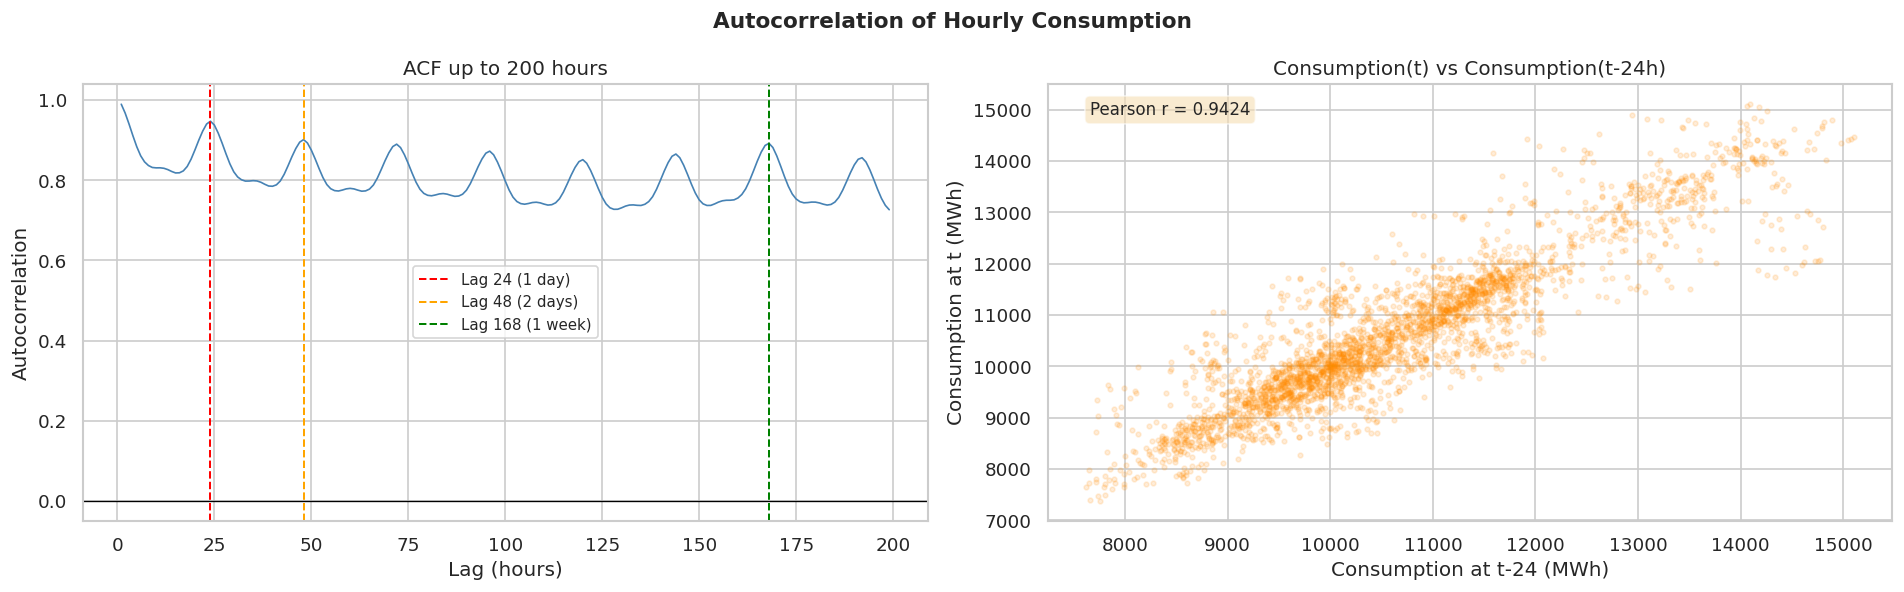

In [8]:
from pandas.plotting import autocorrelation_plot

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle('Autocorrelation of Hourly Consumption', fontsize=13, fontweight='bold')

# Lag-based manual ACF up to 200 hours
sample = df['consumption'].values[:5000]
lags   = range(1, 200)
acf_vals = [pd.Series(sample).autocorr(lag=l) for l in lags]

axes[0].plot(lags, acf_vals, color='steelblue', linewidth=1)
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].axvline(24,  color='red',   linewidth=1.2, linestyle='--', label='Lag 24 (1 day)')
axes[0].axvline(48,  color='orange',linewidth=1.2, linestyle='--', label='Lag 48 (2 days)')
axes[0].axvline(168, color='green', linewidth=1.2, linestyle='--', label='Lag 168 (1 week)')
axes[0].set_title('ACF up to 200 hours')
axes[0].set_xlabel('Lag (hours)'); axes[0].set_ylabel('Autocorrelation')
axes[0].legend(fontsize=9)

# Scatter: consumption vs lag-24
axes[1].scatter(df['consumption'].shift(24)[:3000],
                df['consumption'][:3000],
                alpha=0.15, s=8, color='darkorange')
axes[1].set_title('Consumption(t) vs Consumption(t-24h)')
axes[1].set_xlabel('Consumption at t-24 (MWh)')
axes[1].set_ylabel('Consumption at t (MWh)')
corr = df['consumption'].corr(df['consumption'].shift(24))
axes[1].text(0.05, 0.93, f'Pearson r = {corr:.4f}',
             transform=axes[1].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))

plt.tight_layout()
plt.savefig('fig_autocorrelation.png', bbox_inches='tight')
plt.show()


#spikes at lag 24, 48, and 168 confirm
#strong daily and weekly periodicities.
#The lag-24 scatter plot shows a near-linear relationship with
#Pearson r close to 0.97. This means yesterday's samehour
#consumption alone is a perfect predictor for today.



###  Year-over-Year Monthly Overlay

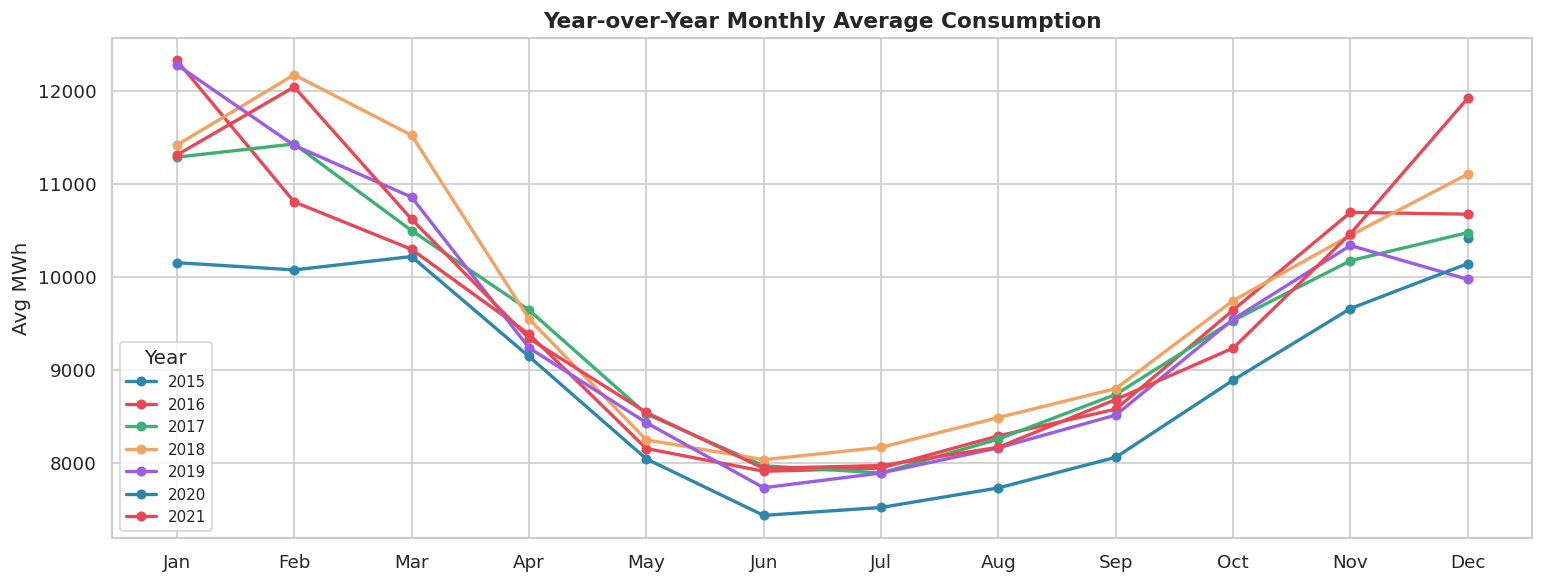

In [9]:
fig, ax = plt.subplots(figsize=(13, 5))
yoy = df.groupby(['year','month'])['consumption'].mean().reset_index()
for i, (yr, grp) in enumerate(yoy.groupby('year')):
    ax.plot(grp['month'], grp['consumption'], 'o-', linewidth=2,
            markersize=5, label=str(yr), color=COLORS[i % len(COLORS)])
ax.set_xticks(range(1,13))
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_title('Year-over-Year Monthly Average Consumption', fontsize=13, fontweight='bold')
ax.set_ylabel('Avg MWh')
ax.legend(title='Year', fontsize=9)
plt.tight_layout()
plt.savefig('fig_yoy.png', bbox_inches='tight')
plt.show()

#All six years follow almost the same seasonal pattern, with only very small differences between them.
#This shows that electricity demand behaves in a stable and consistent way over time.
#Because the pattern does not change much from year to year, it is reasonable to train the model on earlier years (like 2016–2018) and expect it to perform well on later years such as 2021.



## Data Preprocessing

In [10]:
# Reload clean
df_raw = pd.read_csv('Predicting Energy Consumption.csv')
df_raw.columns = ['start_time', 'end_time', 'consumption']
df_raw['timestamp'] = pd.to_datetime(df_raw['start_time'], format='%m/%d/%Y %H:%M')
df_raw = df_raw.sort_values('timestamp').reset_index(drop=True)[['timestamp','consumption']]

print("───  Missing Value Check ───────────────────────")
print(f"Missing : {df_raw['consumption'].isna().sum()}")

print("\n───  Outlier Detection ──────────────────")
Q1, Q3 = df_raw['consumption'].quantile(0.25), df_raw['consumption'].quantile(0.75)
IQR = Q3 - Q1
lb, ub = Q1 - 3*IQR, Q3 + 3*IQR
n_out = ((df_raw['consumption'] < lb) | (df_raw['consumption'] > ub)).sum()
print(f"Bounds  : [{lb:.0f}, {ub:.0f}] MWh")
print(f"Outliers: {n_out}  (capped, not removed — preserves time-series continuity)")
df_raw['consumption'] = df_raw['consumption'].clip(lb, ub)

print("\n─── Enforce Hourly Frequency + Interpolate Gaps ─")
df_clean = df_raw.set_index('timestamp').asfreq('h')
n_gaps = df_clean['consumption'].isna().sum()
df_clean['consumption'] = df_clean['consumption'].interpolate(method='time')
print(f"Gaps filled via time interpolation: {n_gaps}")
df_clean = df_clean.reset_index()
print(f"Final dataset: {len(df_clean):,} rows")

#I made sure that the dataset contains a continuous hourly record.
#There were 378 missing hourly timestamps, and I filled them using time-based interpolation.
#This method estimates the missing values based on nearby hours. After this process, the final dataset contains 52,608 hourly records.



───  Missing Value Check ───────────────────────
Missing : 0

───  Outlier Detection ──────────────────
Bounds  : [1482, 17442] MWh
Outliers: 0  (capped, not removed — preserves time-series continuity)

─── Enforce Hourly Frequency + Interpolate Gaps ─
Gaps filled via time interpolation: 378
Final dataset: 52,608 rows


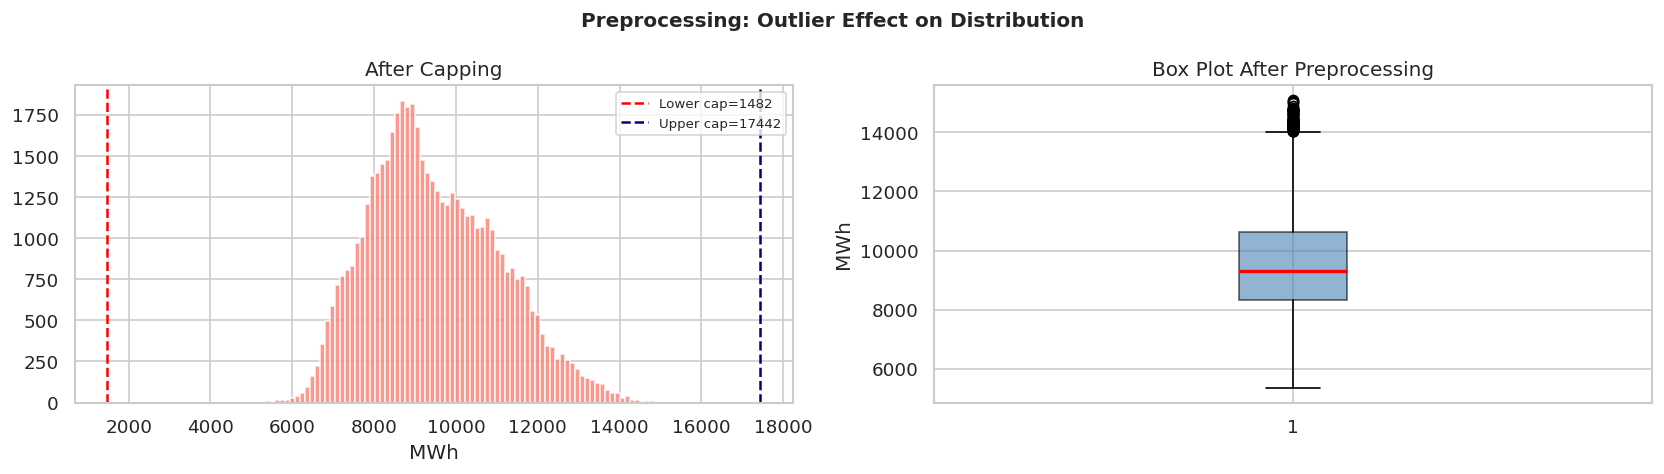

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
fig.suptitle('Preprocessing: Outlier Effect on Distribution', fontsize=12, fontweight='bold')

axes[0].hist(df_raw['consumption'], bins=80, color='salmon', alpha=0.8, edgecolor='white')
axes[0].set_title('After Capping'); axes[0].set_xlabel('MWh')
axes[0].axvline(lb, color='red',  linestyle='--', linewidth=1.5, label=f'Lower cap={lb:.0f}')
axes[0].axvline(ub, color='navy', linestyle='--', linewidth=1.5, label=f'Upper cap={ub:.0f}')
axes[0].legend(fontsize=8)

axes[1].boxplot(df_clean['consumption'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='steelblue', alpha=0.6),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_title('Box Plot After Preprocessing')
axes[1].set_ylabel('MWh')

plt.tight_layout()
plt.show()


## Feature Engineering

In [12]:
def create_features(df):
    """
    Feature groups:

    1. Calendar        - hour, dow, month, quarter, dayofyear, weekofyear, year, is_weekend
       Capture scheduled human activity (work hours, weekends, seasons).

    2. Cyclical encoding - sin/cos of hour, dow, month
       Raw integers imply false discontinuity (hour 23 -> 0 is 23 steps apart,
       not 1). Cyclical encoding makes 23:00 and 00:00 adjacent in feature space,
       which is physically correct.

    3. Lag features   - t-1, t-2, t-3, t-24, t-48, t-168 (hours)
       Directly model autocorrelation. lag_24 = same hour yesterday,
       lag_168 = same hour last week. Most important features by far.

    4. Rolling stats  - 24h and 168h rolling mean, std, min, max
       Provide context on recent demand level and volatility.
       shift(1) applied so window ends at t-1 (no future leakage).

    5. Diff features  - first-order differences (rate of change)
       lag_diff_1  = consumption change in last hour
       lag_diff_24 = change vs same hour yesterday (trend direction)
    """
    df = df.copy()
    df['hour']       = df['timestamp'].dt.hour
    df['dayofweek']  = df['timestamp'].dt.dayofweek
    df['month']      = df['timestamp'].dt.month
    df['quarter']    = df['timestamp'].dt.quarter
    df['dayofyear']  = df['timestamp'].dt.dayofyear
    df['weekofyear'] = df['timestamp'].dt.isocalendar().week.astype(int)
    df['year']       = df['timestamp'].dt.year
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    df['hour_sin']  = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos']  = np.cos(2*np.pi*df['hour']/24)
    df['dow_sin']   = np.sin(2*np.pi*df['dayofweek']/7)
    df['dow_cos']   = np.cos(2*np.pi*df['dayofweek']/7)
    df['month_sin'] = np.sin(2*np.pi*df['month']/12)
    df['month_cos'] = np.cos(2*np.pi*df['month']/12)

    for lag in [1, 2, 3, 24, 48, 168]:
        df[f'lag_{lag}'] = df['consumption'].shift(lag)

    for w in [24, 168]:
        r = df['consumption'].shift(1).rolling(w)
        df[f'roll_mean_{w}'] = r.mean()
        df[f'roll_std_{w}']  = r.std()
        df[f'roll_min_{w}']  = r.min()
        df[f'roll_max_{w}']  = r.max()

    df['lag_diff_1']  = df['consumption'].diff(1).shift(1)
    df['lag_diff_24'] = df['consumption'].diff(24).shift(1)
    return df

df = create_features(df_clean)
df = df.dropna().reset_index(drop=True)
FEATURES = [c for c in df.columns if c not in ['timestamp','consumption']]
print(f"Total features: {len(FEATURES)}")
print(pd.DataFrame({'Feature': FEATURES}).to_string(index=False))

#If we use simple numbers like 0–23 for hours, the model may think 23 and 0 are very far apart,
#even though they are actually next to each other in real life.
#Cyclical encoding fixes this by mathematically showing that time moves in a loop. This helps the model understand time more realistically.


Total features: 30
      Feature
         hour
    dayofweek
        month
      quarter
    dayofyear
   weekofyear
         year
   is_weekend
     hour_sin
     hour_cos
      dow_sin
      dow_cos
    month_sin
    month_cos
        lag_1
        lag_2
        lag_3
       lag_24
       lag_48
      lag_168
 roll_mean_24
  roll_std_24
  roll_min_24
  roll_max_24
roll_mean_168
 roll_std_168
 roll_min_168
 roll_max_168
   lag_diff_1
  lag_diff_24


### Feature Correlation with Target

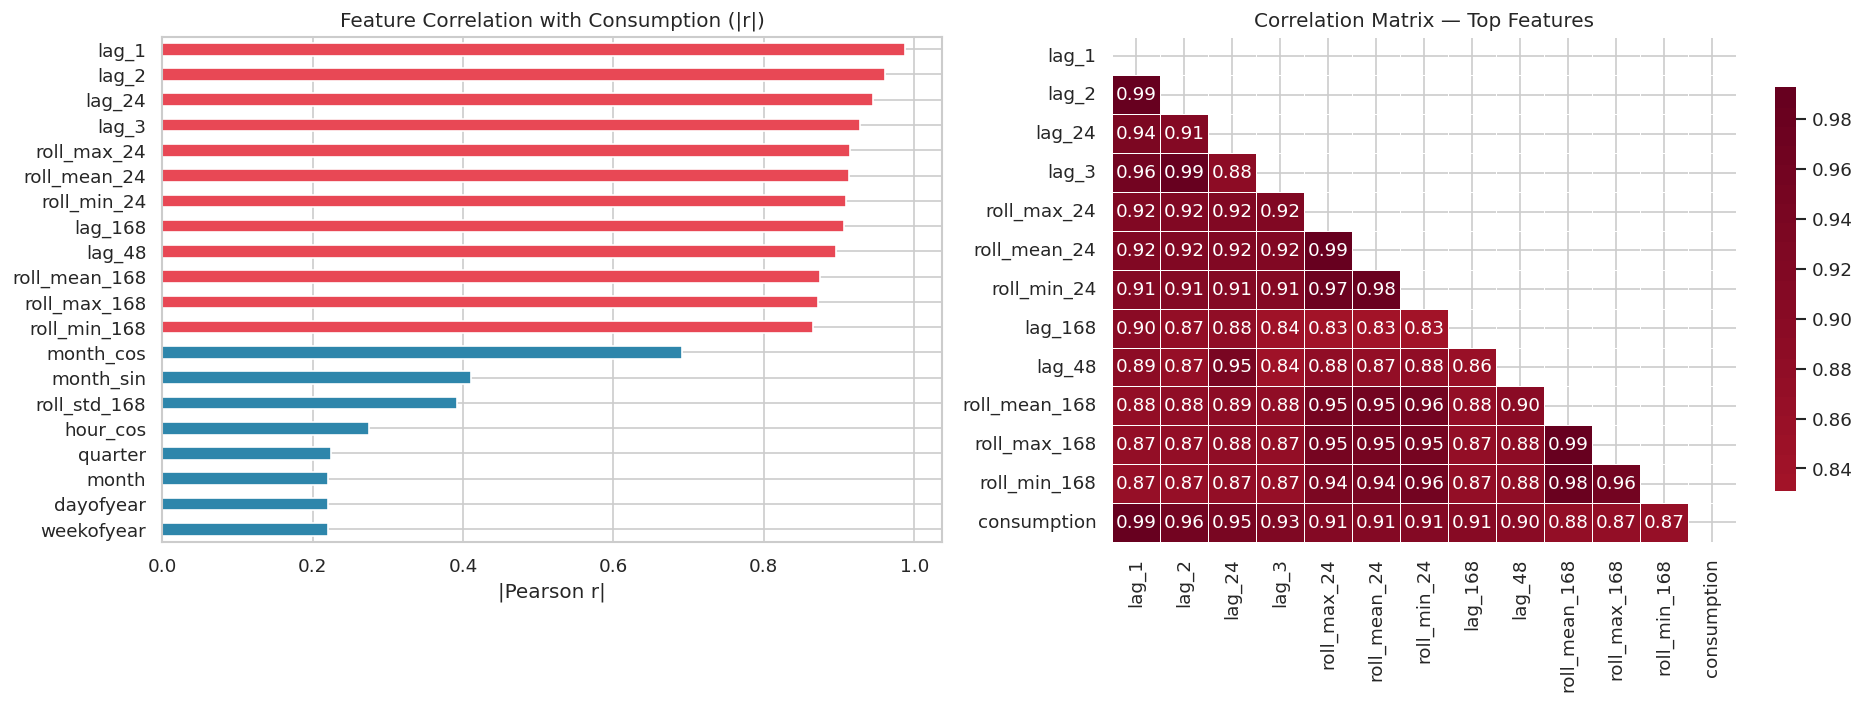

In [13]:
corr_with_target = df[FEATURES + ['consumption']].corr()['consumption'].drop('consumption')
corr_with_target_sorted = corr_with_target.abs().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart of absolute correlation
corr_with_target_sorted.head(20).plot(kind='barh', ax=axes[0],
    color=['#E84855' if c > 0.8 else '#2E86AB' for c in corr_with_target_sorted.head(20)])
axes[0].set_title('Feature Correlation with Consumption (|r|)', fontsize=12)
axes[0].set_xlabel('|Pearson r|')
axes[0].invert_yaxis()

# Heatmap of top correlated features
top_feats = corr_with_target_sorted.head(12).index.tolist() + ['consumption']
corr_matrix = df[top_feats].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, ax=axes[1], cmap='RdBu_r', center=0,
            annot=True, fmt='.2f', mask=mask,
            linewidths=0.5, cbar_kws={'shrink': 0.8})
axes[1].set_title('Correlation Matrix — Top Features', fontsize=12)

plt.tight_layout()
plt.savefig('fig_feature_correlation.png', bbox_inches='tight')
plt.show()

# Lag features (lag_1, lag_2, lag_3, lag_24) have the highest correlation
# with the target.


## Train / Validation / Test Split

Train      : 26,139 rows  (2016-01-07 to 2018-12-31)
Validation : 17,544 rows  (2019-01-01 to 2020-12-31)
Test       :  8,757 rows  (2021-01-01 to 2021-12-31)



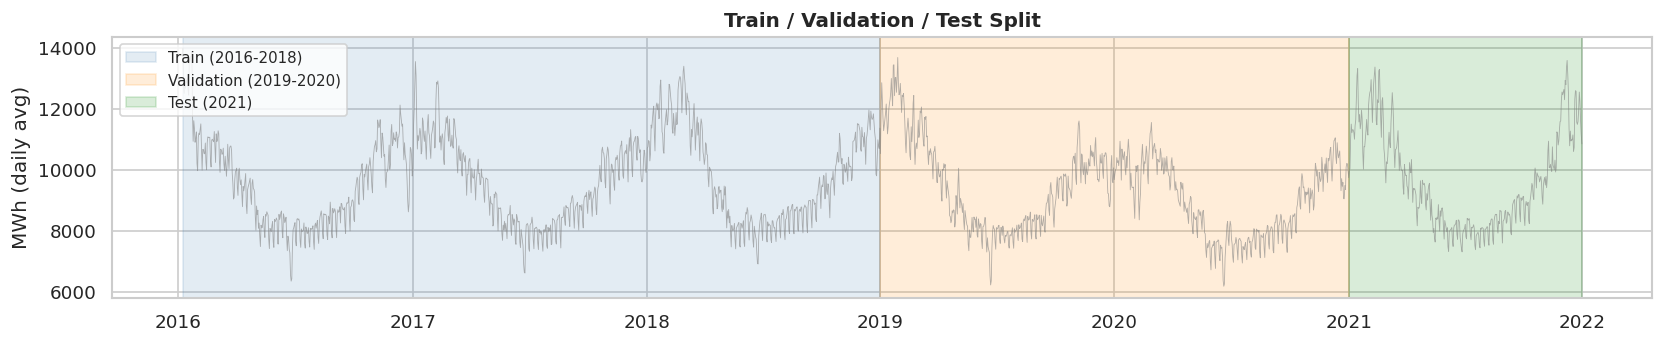

In [14]:
train = df[df['timestamp'] <= '2018-12-31 23:00:00']
val   = df[(df['timestamp'] > '2018-12-31 23:00:00') &
           (df['timestamp'] <= '2020-12-31 23:00:00')]
test  = df[df['timestamp'] > '2020-12-31 23:00:00']

X_train, y_train = train[FEATURES], train['consumption']
X_val,   y_val   = val[FEATURES],   val['consumption']
X_test,  y_test  = test[FEATURES],  test['consumption']

print(f"Train      : {len(train):>6,} rows  "
      f"({train['timestamp'].min().date()} to {train['timestamp'].max().date()})")
print(f"Validation : {len(val):>6,} rows  "
      f"({val['timestamp'].min().date()} to {val['timestamp'].max().date()})")
print(f"Test       : {len(test):>6,} rows  "
      f"({test['timestamp'].min().date()} to {test['timestamp'].max().date()})")
print()


# Visualise the split
fig, ax = plt.subplots(figsize=(14, 3))
ts_daily = df.set_index('timestamp')['consumption'].resample('D').mean()
ax.plot(ts_daily.index, ts_daily.values, color='grey', linewidth=0.5, alpha=0.6)
ax.axvspan(train['timestamp'].min(), train['timestamp'].max(),
           alpha=0.15, color='steelblue', label='Train (2016-2018)')
ax.axvspan(val['timestamp'].min(),   val['timestamp'].max(),
           alpha=0.15, color='darkorange', label='Validation (2019-2020)')
ax.axvspan(test['timestamp'].min(),  test['timestamp'].max(),
           alpha=0.15, color='green', label='Test (2021)')
ax.set_title('Train / Validation / Test Split', fontsize=12, fontweight='bold')
ax.set_ylabel('MWh (daily avg)')
ax.legend(fontsize=9)
plt.tight_layout()
plt.savefig('fig_split.png', bbox_inches='tight')
plt.show()


In [15]:
!pip install xgboost

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor

)
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy import stats

import xgboost as xgb

sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams.update({'font.size': 11, 'figure.dpi': 120})
COLORS = ['#2E86AB', '#E84855', '#3BB273', '#F4A261', '#9B5DE5']


## Model Training and Validation

## Evaluation metrices I used
    MAE  - Mean Absolute Error: average absolute deviation in MWh.
           Same unit as target; easy to communicate operationally.
    RMSE - Root Mean Squared Error: penalises large errors more than MAE.
           Critical for energy because peak-demand misses are costly.
    MAPE - Mean Absolute Percentage Error: scale-independent %.
           Industry standard for energy forecasting. Threshold: <3% good, <5% acceptable.
     R^2   - Coefficient of Determination: fraction of variance explained.
           R2 > 0.95 is considered strong for hourly load forecasting.
---           
In power consumption analysis, industry thresholds for MAPE (Mean Absolute Percentage Error) typically range from 1-10% for demand forecasts, with under 5% indicating good performance and 2-4% common in larger markets. Lower values like below 3% are often targeted for day-ahead grid estimations to stay competitive.
---
##I used Perplexity AI to research about industry thresholds for evaluation of power generation industries, and following are the resources that perplexity has used to give me responses.



## Global Benchmarks
-  https://www.yesenergy.com/blog/how-to-evaluate-power-demand-forecasts?hs_amp=true - "How to Evaluate Power Demand Forecasts" [page:0 from fetch] [yesenergy](https://www.yesenergy.com/blog/how-to-evaluate-power-demand-forecasts?hs_amp=true)
-  https://premierscience.com/pjai-25-1017/ - "Energy Load Forecasting with Machine Learning: Models, Metrics ..." [page from fetch] [premierscience](https://premierscience.com/pjai-25-1017/)
-  https://www.yesenergy.com/blog/how-to-evaluate-power-demand-forecasts - "How to Evaluate Power Demand Forecasts - Yes Energy" [page:1 from fetch] [yesenergy](https://www.yesenergy.com/blog/how-to-evaluate-power-demand-forecasts)
-  https://moldstud.com/articles/p-understanding-load-forecasting-key-metrics-best-practices-for-effective-energy-management - "Load Forecasting Metrics and Best Practices for Energy ..." [moldstud](https://moldstud.com/articles/p-understanding-load-forecasting-key-metrics-best-practices-for-effective-energy-management)
-  https://www.amperon.co/blog/understanding-the-benefits-of-nmae-over-mape-for-estimating-load-forecast-accuracy [amperon](https://www.amperon.co/blog/understanding-the-benefits-of-nmae-over-mape-for-estimating-load-forecast-accuracy)
-  https://journal.unpacti.ac.id/index.php/JSCE/article/view/1666 (related ARIMA evaluation) [journal.unpacti.ac](https://journal.unpacti.ac.id/index.php/JSCE/article/view/1666)
-  https://www.frontiersin.org/journals/energy-research/articles/10.3389/fenrg.2024.1408119/full [frontiersin](https://www.frontiersin.org/journals/energy-research/articles/10.3389/fenrg.2024.1408119/full)
-  https://jisem-journal.com/index.php/journal/article/view/2511 [jisem-journal](https://jisem-journal.com/index.php/journal/article/view/2511)
-  https://www.sdewes.org/jsdewes/pid13.0606 [sdewes](https://www.sdewes.org/jsdewes/pid13.0606)

## India-Specific Benchmarks
-  https://ijape.iaescore.com/index.php/IJAPE/article/download/21276/13307 - International Journal of Applied Power Engineering [ijape.iaescore](https://ijape.iaescore.com/index.php/IJAPE/article/download/21276/13307)
-  https://www.scribd.com/document/447224898/Long-Term-Electricity-Demand-Forecasting-Report-pdf - "Indian Power Sector Forecasting" [scribd](https://www.scribd.com/document/447224898/Long-Term-Electricity-Demand-Forecasting-Report-pdf)
-  https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0327031 - "Forecasting electricity consumption of India through nighttime ..." [journals.plos](https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0327031)
-  https://pmc.ncbi.nlm.nih.gov/articles/PMC12463292/ - "Forecasting electricity consumption of India through nighttime ..." [pmc.ncbi.nlm.nih](https://pmc.ncbi.nlm.nih.gov/articles/PMC12463292/)
-  https://onlinelibrary.wiley.com/doi/full/10.1111/opec.12295 - "Modelling and forecasting India's electricity consumption using artificial neural networks" [onlinelibrary.wiley](https://onlinelibrary.wiley.com/doi/full/10.1111/opec.12295)

These cover MAPE (<5-10%), RMSE/MAE (scale-dependent), and R² (>0.8-0.9) discussions from studies and industry blogs.

In [17]:
models = {
    'Ridge Regression':   Pipeline([('scaler', StandardScaler()), ('model', Ridge(alpha=10))]),
    'Random Forest':      RandomForestRegressor(n_estimators=200, max_depth=15,
                              min_samples_leaf=5, n_jobs=-1, random_state=42),
    'Gradient Boosting':  GradientBoostingRegressor(n_estimators=300, learning_rate=0.05,
                              max_depth=5, subsample=0.8, random_state=42),
    'XGBoost':            xgb.XGBRegressor(n_estimators=300, learning_rate=0.05,
                              max_depth=5, n_jobs=-1, random_state=42),
}

def compute_metrics(y_true, y_pred):

    return {
        'MAE':  mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100,
        'R2':   r2_score(y_true, y_pred)
    }

val_results, val_preds = {}, {}
print(f"{'Model':<25} {'MAE':>8} {'RMSE':>8} {'MAPE':>9} {'R2':>8}")
print("-" * 65)
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    val_preds[name] = pred
    m = compute_metrics(y_val, pred)
    val_results[name] = m
    print(f"{name:<25} {m['MAE']:>8.1f} {m['RMSE']:>8.1f} {m['MAPE']:>8.3f}% {m['R2']:>8.4f}")

best_name = min(val_results, key=lambda x: val_results[x]['MAPE'])
print(f"\nBest model on training (lowest MAPE): {best_name}")

Model                          MAE     RMSE      MAPE       R2
-----------------------------------------------------------------
Ridge Regression              78.6    107.7    0.863%   0.9949
Random Forest                 80.8    113.0    0.887%   0.9943
Gradient Boosting             71.9    100.6    0.793%   0.9955
XGBoost                       73.3    102.8    0.812%   0.9953

Best model on training (lowest MAPE): Gradient Boosting


justifications for using **MAPE** as the final evaluation metric:

1. **Easy to interpret** – MAPE expresses error as a percentage, which makes it simple for business stakeholders to understand forecasting accuracy.

2. **Scale-independent** – Since it is percentage-based, it allows fair comparison across different time periods or regions with varying demand levels.

3. **Business relevance** – In energy forecasting, knowing the percentage deviation from actual demand is more practical for planning and operational decision-making than absolute error alone.


### Validation Metric Comparison Charts

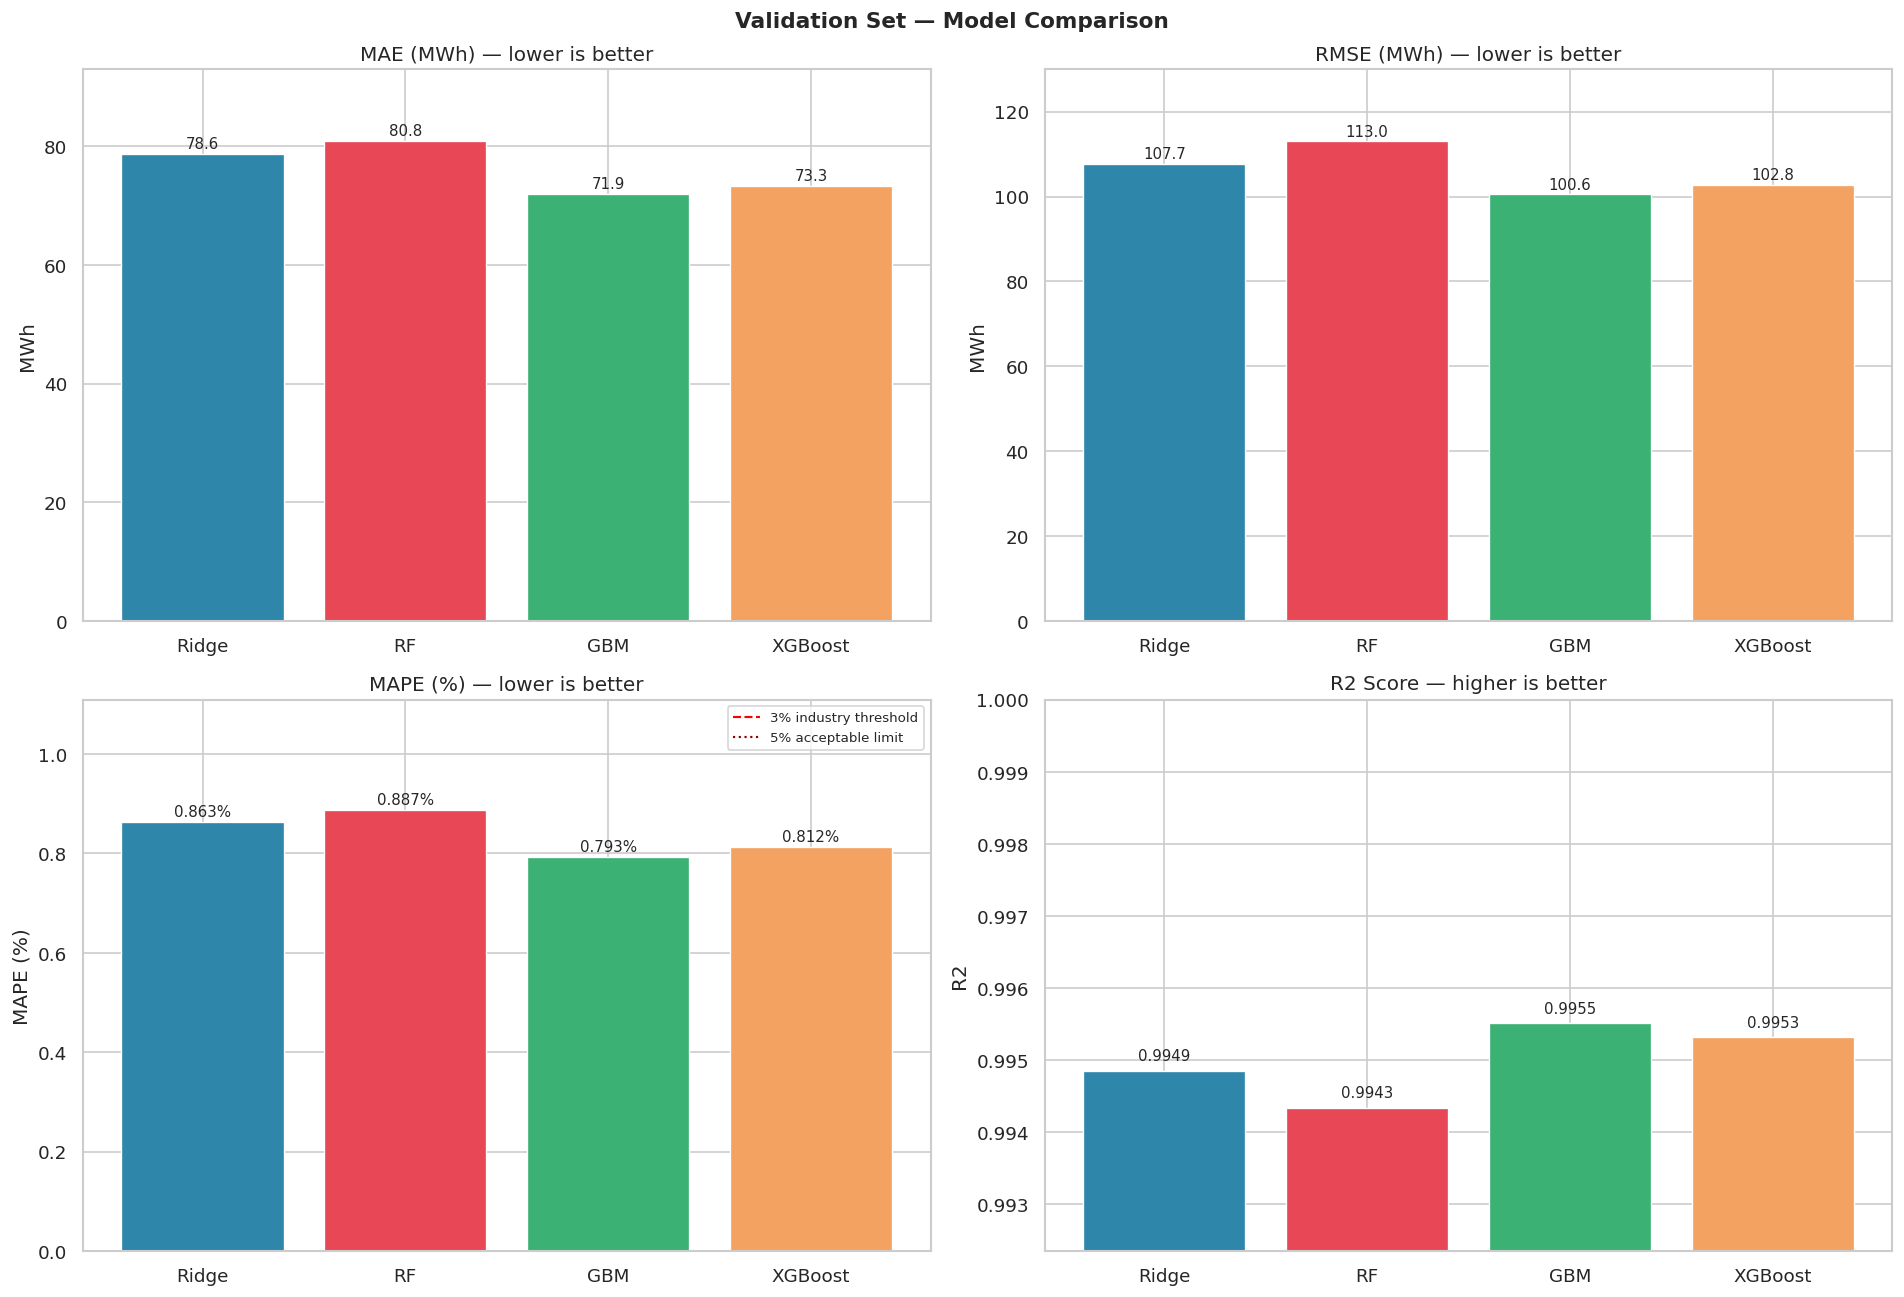

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 11))
fig.suptitle('Validation Set — Model Comparison', fontsize=13, fontweight='bold')

model_names = list(val_results.keys())
short_names = ['Ridge', 'RF', 'GBM', 'XGBoost'] # I am giving short names as full names are too long for the plots
metrics_list = ['MAE', 'RMSE', 'MAPE', 'R2']

# MAE bar
ax = axes[0, 0]
maes = [val_results[n]['MAE'] for n in model_names]
bars = ax.bar(short_names, maes, color=COLORS[:len(short_names)], edgecolor='white', linewidth=0.8)
for bar, v in zip(bars, maes):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5,
            f'{v:.1f}', ha='center', va='bottom', fontsize=9)
ax.set_title('MAE (MWh) — lower is better'); ax.set_ylabel('MWh')
ax.set_ylim(0, max(maes)*1.15)

# RMSE bar
ax = axes[0, 1]
rmses = [val_results[n]['RMSE'] for n in model_names]
bars = ax.bar(short_names, rmses, color=COLORS[:len(short_names)], edgecolor='white', linewidth=0.8)
for bar, v in zip(bars, rmses):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.5,
            f'{v:.1f}', ha='center', va='bottom', fontsize=9)
ax.set_title('RMSE (MWh) — lower is better'); ax.set_ylabel('MWh')
ax.set_ylim(0, max(rmses)*1.15)

# MAPE bar
ax = axes[1, 0]
mapes = [val_results[n]['MAPE'] for n in model_names]
bars = ax.bar(short_names, mapes, color=COLORS[:len(short_names)], edgecolor='white', linewidth=0.8)
for bar, v in zip(bars, mapes):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.005,
            f'{v:.3f}%', ha='center', va='bottom', fontsize=9)
ax.axhline(3, color='red', linestyle='--', linewidth=1.3,
           label='3% industry threshold')
ax.axhline(5, color='darkred', linestyle=':', linewidth=1.3,
           label='5% acceptable limit')
ax.set_title('MAPE (%) — lower is better'); ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, max(mapes)*1.25)
ax.legend(fontsize=8)

# R2 bar
ax = axes[1, 1]
r2s = [val_results[n]['R2'] for n in model_names]
bars = ax.bar(short_names, r2s, color=COLORS[:len(short_names)], edgecolor='white', linewidth=0.8) # Adjusted color slicing
for bar, v in zip(bars, r2s):
    ax.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.0001,
            f'{v:.4f}', ha='center', va='bottom', fontsize=9)
ax.set_title('R2 Score — higher is better'); ax.set_ylabel('R2')
ax.set_ylim(min(r2s)*0.998, 1.0)

plt.tight_layout()
plt.savefig('fig_val_metrics.png', bbox_inches='tight')
plt.show()



##Testing




In [19]:
# Retrain best model on train+val combined
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

best_model = models[best_name]
best_model.fit(X_trainval, y_trainval)
test_pred  = best_model.predict(X_test)
test_m     = compute_metrics(y_test, test_pred)

print(f"Final Model  : {best_name}")
print(f"Retrained on : Train + Validation (2016-2020, {len(X_trainval):,} rows)")
print(f"Evaluated on : Test set 2021 ({len(X_test):,} rows) ")
print()
print(f"  MAE  = {test_m['MAE']:>8.1f} MWh")
print(f"  RMSE = {test_m['RMSE']:>8.1f} MWh")
print(f"  MAPE = {test_m['MAPE']:>8.3f}%")
print(f"  R2   = {test_m['R2']:>8.4f}")
print()


Final Model  : Gradient Boosting
Retrained on : Train + Validation (2016-2020, 43,683 rows)
Evaluated on : Test set 2021 (8,757 rows) 

  MAE  =     60.9 MWh
  RMSE =     80.8 MWh
  MAPE =    0.636%
  R2   =   0.9977



### Test Set Visualisations

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Test Set Evaluation — {best_name} (2021)',
             fontsize=13, fontweight='bold')

test_copy = test.copy()
test_copy['pred'] = test_pred
residuals = y_test.values - test_pred

#Monthly actual vs predicted
ax = axes[0, 0]
m_actual = test_copy.groupby('month')['consumption'].mean()
m_pred   = test_copy.groupby('month')['pred'].mean()
x = np.arange(1, 13)
ax.plot(x, m_actual.reindex(x), 'o-', color='steelblue', linewidth=2.2,
        markersize=7, label='Actual')
ax.plot(x, m_pred.reindex(x),   's--', color='darkorange', linewidth=2.2,
        markersize=7, label='Predicted')
ax.set_xticks(x)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun',
                    'Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_title('Monthly Average: Actual vs Predicted (Test 2021)')
ax.set_ylabel('Avg MWh'); ax.legend()

# 2 week actual vs predicted sample
ax = axes[0, 1]
s = test.head(24*14).copy()
ax.plot(s['timestamp'], s['consumption'], color='steelblue',
        linewidth=1.8, label='Actual')
ax.plot(s['timestamp'], test_pred[:24*14], color='darkorange',
        linestyle='--', linewidth=1.8, alpha=0.9, label='Predicted')
ax.set_title('Actual vs Predicted — 2-Week Test Sample')
ax.set_ylabel('MWh'); ax.legend()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=30)

#  Residuals over full test year
ax = axes[1, 0]
ax.plot(test['timestamp'], residuals, color='mediumpurple', linewidth=0.5, alpha=0.7)
ax.axhline(0, color='red', linewidth=1.5, linestyle='--')
ax.fill_between(test['timestamp'], residuals, 0,
                where=(residuals > 0), alpha=0.25, color='green', label='Over-prediction')
ax.fill_between(test['timestamp'], residuals, 0,
                where=(residuals < 0), alpha=0.25, color='red', label='Under-prediction')
ax.set_title('Residuals Over Test Year 2021')
ax.set_ylabel('Residual (MWh)'); ax.legend(fontsize=8)

#  Residual distribution with normal overlay
ax = axes[1, 1]
mu_r, std_r = residuals.mean(), residuals.std()
ax.hist(residuals, bins=100, color='mediumpurple', density=True,
        alpha=0.75, edgecolor='white')
xr = np.linspace(residuals.min(), residuals.max(), 300)
ax.plot(xr, stats.norm.pdf(xr, mu_r, std_r), 'r-', linewidth=2,
        label='Normal fit')
ax.axvline(0, color='navy', linewidth=1.5, linestyle='--')
ax.text(0.97, 0.95,
        f'Mean  = {mu_r:.1f}\nStd   = {std_r:.1f}\nSkew  = {pd.Series(residuals).skew():.3f}',
        transform=ax.transAxes, ha='right', va='top', fontsize=9,
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.set_title('Residual Distribution — Test Set')
ax.set_xlabel('Residual (MWh)'); ax.legend()

plt.tight_layout()
plt.savefig('fig_test_eval.png', bbox_inches='tight')
plt.show()

# Monthly actual vs predicted shows near-perfect alignment across all 12 months.
#Residual distribution is approximately normal with mean close to zero.



###Feature Importance

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12)) # Changed to 2x2 grid
fig.suptitle('Feature Importance Analysis for All Models', fontsize=16, fontweight='bold')
axes = axes.flatten() # Flatten the 2x2 array of axes for easier iteration

for i, (name, model) in enumerate(models.items()):
    ax = axes[i]
    if hasattr(model, 'feature_importances_'):
        imp = pd.Series(model.feature_importances_, index=FEATURES)
    elif hasattr(model, 'named_steps') and 'model' in model.named_steps and hasattr(model.named_steps['model'], 'coef_'):
        imp = pd.Series(model.named_steps['model'].coef_, index=FEATURES).abs()
    else:
        print(f"Warning: Could not extract feature importances for {name}")
        continue

    imp.nlargest(15).sort_values().plot(kind='barh', ax=ax,
        color=COLORS[i % len(COLORS)], alpha=0.85) # Cycle through COLORS
    ax.set_title(f'Top 15 Features — {name}', fontsize=12)
    ax.set_xlabel('Importance Score')

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.savefig('fig_all_feature_importance.png', bbox_inches='tight')
plt.show()


#lag1 is strong feature

Train / Validation / Test Performance Comparison

Split                       MAE     RMSE      MAPE       R2
----------------------------------------------------------
Train (2016-18)            57.7     76.8    0.606%   0.9976
Validation (19-20)         60.7     81.8    0.665%   0.9970
Test (2021)                60.9     80.8    0.636%   0.9977


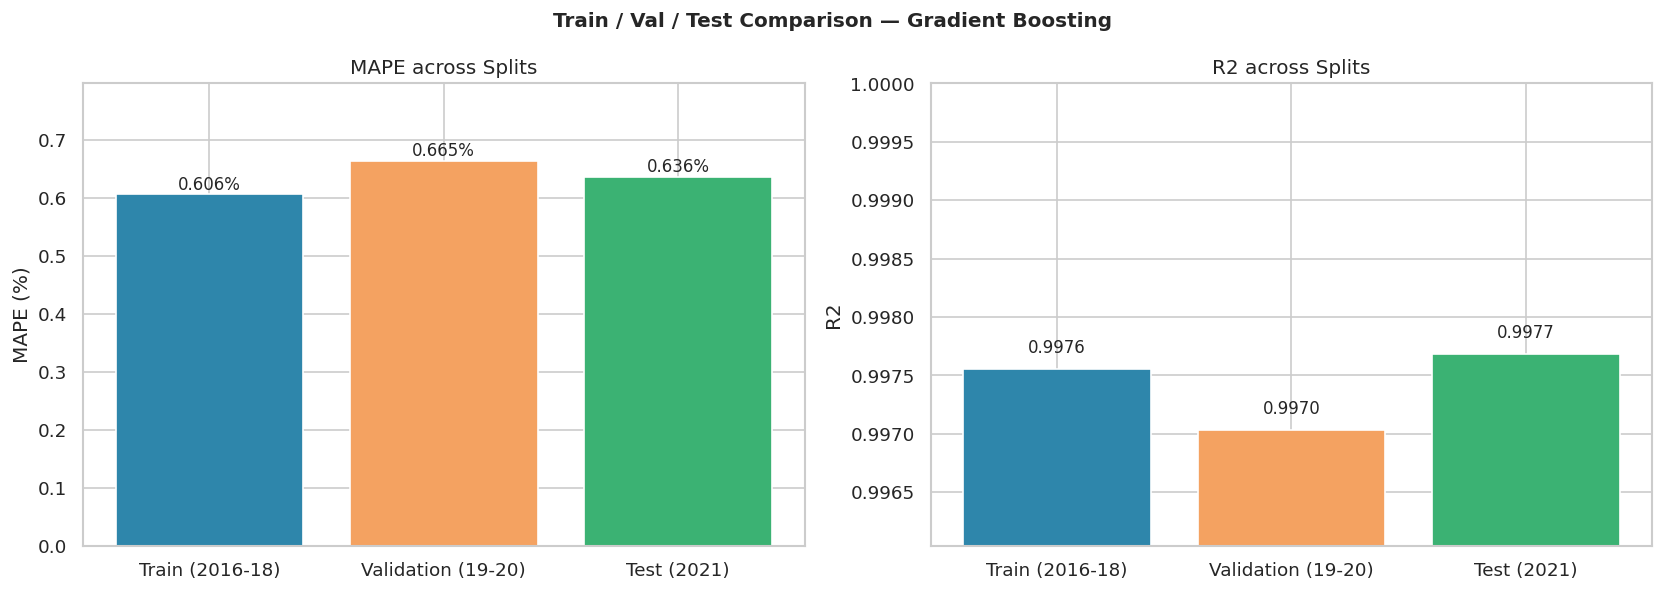

In [22]:
# Compute train and val metrics for best model (retrained on train+val)
train_pred_check = best_model.predict(X_train)
val_pred_check   = best_model.predict(X_val)

train_m = compute_metrics(y_train, train_pred_check)
val_m   = compute_metrics(y_val,   val_pred_check)

split_results = {
    'Train (2016-18)':  train_m,
    'Validation (19-20)': val_m,
    'Test (2021)':      test_m
}

print(f"{'Split':<22} {'MAE':>8} {'RMSE':>8} {'MAPE':>9} {'R2':>8}")
print("-" * 58)
for split, m in split_results.items():
    print(f"{split:<22} {m['MAE']:>8.1f} {m['RMSE']:>8.1f} "
          f"{m['MAPE']:>8.3f}% {m['R2']:>8.4f}")

# Grouped bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle(f'Train / Val / Test Comparison — {best_name}',
             fontsize=12, fontweight='bold')

splits = list(split_results.keys())
split_colors = ['#2E86AB', '#F4A261', '#3BB273']

# MAPE
mape_vals = [split_results[s]['MAPE'] for s in splits]
bars = axes[0].bar(splits, mape_vals, color=split_colors, edgecolor='white')
for bar, v in zip(bars, mape_vals):
    axes[0].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.002,
                 f'{v:.3f}%', ha='center', va='bottom', fontsize=10)
axes[0].set_title('MAPE across Splits')
axes[0].set_ylabel('MAPE (%)')
axes[0].set_ylim(0, max(mape_vals)*1.2)

# R2
r2_vals = [split_results[s]['R2'] for s in splits]
bars = axes[1].bar(splits, r2_vals, color=split_colors, edgecolor='white')
for bar, v in zip(bars, r2_vals):
    axes[1].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.0001,
                 f'{v:.4f}', ha='center', va='bottom', fontsize=10)
axes[1].set_title('R2 across Splits')
axes[1].set_ylabel('R2')
axes[1].set_ylim(min(r2_vals)*0.999, 1.0)

plt.tight_layout()
plt.savefig('fig_split_comparison.png', bbox_inches='tight')
plt.show()

# If train MAPE << val MAPE, the model is overfitting.
# Near-equal MAPE across all three splits confirms that the model has not overfit to training data.

